In [33]:
# %load_ext nb_black

import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE  # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
warnings.filterwarnings("ignore")
randomseed = 7

In [53]:
maindata= pd.read_csv('../../DATASET_2019-10-24_light.txt',sep=',')

In [54]:
data1 = pd.read_csv("NextYearData_actualData_train.txt")
data2 = pd.read_csv("ThisYearData_actualData_train.txt")
data3 = pd.read_csv("ThisYearData_actualData_test.txt")

data4 = pd.read_csv("NextYearData_actualData_test.txt")

data5 = pd.read_csv("Predicted_NextYearData.txt")

data = pd.concat([data1, data2, data3])

print(data.shape)
data.head()

(1680, 18)


,Unnamed: 0,FIELD_1,FIELD_2,L100700,S000300,L101700,L103300,L103100,L190900,L504700,L190300,L103000,FIELD_15,FIELD_38,FIELD_33,SEX,AGE,CLASS
0,0,123111,20140729,4.2,18.9,13.0,2.3,75.0,13.0,0.86,4.45,64.0,0.0,2.0,1.0,1.0,25.0,1
1,1,247895,20150729,6.1,23.5,26.0,4.6,43.0,12.7,0.60,4.50,114.0,0.0,1.0,3.0,0.0,29.0,1
2,2,273354,20141111,4.1,18.6,29.0,2.1,89.0,12.9,1.00,4.51,76.0,0.0,3.0,3.0,1.0,29.0,1
3,3,273354,20151215,4.0,19.7,43.0,1.9,105.0,13.6,0.70,4.48,34.0,0.0,5.0,3.0,1.0,30.0,1
4,4,299264,20150729,6.9,29.4,87.0,6.1,35.0,13.1,2.90,5.31,242.0,0.0,1.0,1.0,0.0,30.0,1


In [55]:
# exclude test data from the main data
tempdata= pd.merge(maindata,data4[['FIELD_1','FIELD_2']],  how='inner', 
                   left_on=['FIELD_1','FIELD_2'], right_on=['FIELD_1','FIELD_2'])
maindata=maindata[~maindata['Unnamed: 0'].isin(tempdata[['Unnamed: 0']].values.ravel())]

In [56]:
maindata=maindata[['L100700','S000300','L101700','L103300','L190900','L504700','L103000','L103100',
                   'L190300','FIELD_15','FIELD_38','FIELD_33','SEX','AGE','CLASS']].dropna()

print(maindata.groupby(by='CLASS').size())

mydata=maindata.copy()

from sklearn.utils import shuffle

CLASS
0    354541
1      3017
dtype: int64


In [57]:
# # print(data.groupby(by='CLASS').size())
# # maindata=data.copy()

# class0=maindata[maindata.CLASS==0]
# class1=maindata[maindata.CLASS==1]

# class0=class0.sample(3*class1.shape[0],random_state=42)

# data=pd.concat([class1,class0])

# print(data.shape)


In [58]:
class1 = mydata[mydata.CLASS == 1]
class0 = mydata[mydata.CLASS == 0]

print(class1.shape[0],class0.shape[0],)

class1_test = class1.sample(200, random_state=42)
class0_test = class0.sample(200, random_state=42)
test = pd.concat([class1_test, class0_test])
test=shuffle(test)


class1_train = class1.drop(class1_test.index) #.sample( class2_train.shape[0], random_state=randomseed)
class0_train = class0.drop(class0_test.index) .sample( 10*class1_train.shape[0], random_state=randomseed)

train = pd.concat([class1_train, class0_train])
train=shuffle(train, random_state=42)

print(train.groupby('CLASS').size())

3017 354541
CLASS
0    28170
1     2817
dtype: int64


In [59]:
# generate synthetic dataset to overcome class imbalance
from collections import Counter
from numpy.random import RandomState
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(random_state=42, categorical_features=[2,9,10,11],k_neighbors=3,sampling_strategy = 1)
X_res, y_res = sm.fit_resample(train.iloc[:,:-1],train.iloc[:,-1])
print("Resampled dataset samples per class {}".format(Counter(y_res)))

train=pd.DataFrame(X_res,columns=list(train.columns[:-1]))
train['CLASS']=y_res

Resampled dataset samples per class Counter({0: 28170, 1: 28170})


In [60]:
# xtrain, xtest, ytrain, ytest = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], random_state=42, test_size=0.3)

xtrain=train.iloc[:,:-1]
xtest=test.iloc[:,:-1] 
ytrain=train.iloc[:,-1]
ytest=test.iloc[:,-1] 

In [61]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    random_state=randomseed,
    n_estimators=1000,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features=8,
)
rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

0.6


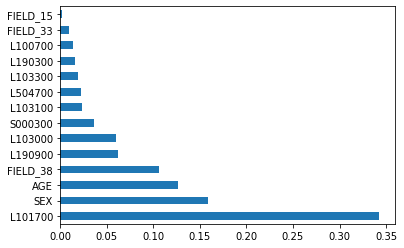

Index(['L101700', 'SEX', 'AGE', 'FIELD_38', 'L190900', 'L103000', 'S000300',
       'L103100', 'L504700', 'L103300', 'L190300', 'L100700', 'FIELD_33',
       'FIELD_15'],
      dtype='object')


In [62]:
ypred = rf.predict(xtest)

score = rf.score(xtest, ytest)
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=xtest.columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)

In [63]:
print("Accuracy on training set: {:.3f}".format(rf.score(xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(rf.score(xtest, ytest)))

confmatrx = pd.DataFrame(m.confusion_matrix(ytest, ypred))
confmatrx.head()

Accuracy on training set: 0.870
Accuracy on test set: 0.600


,0,1
0,175,25
1,135,65


In [64]:
from sklearn.metrics import classification_report

print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.56      0.88      0.69       200
           1       0.72      0.33      0.45       200

    accuracy                           0.60       400
   macro avg       0.64      0.60      0.57       400
weighted avg       0.64      0.60      0.57       400



In [65]:
import xgboost as xgb
from sklearn import metrics as m

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=randomseed)

xgb_model.fit(xtrain, ytrain)

y_pred = xgb_model.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

accuracy 	 0.6075


,0,1
0,176,24
1,133,67


In [66]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.88      0.69       200
           1       0.74      0.34      0.46       200

    accuracy                           0.61       400
   macro avg       0.65      0.61      0.58       400
weighted avg       0.65      0.61      0.58       400



In [67]:
data4=data4[['L100700','S000300','L101700','L103300','L190900','L504700','L103000','L103100',
                   'L190300','FIELD_15','FIELD_38','FIELD_33','SEX','AGE','CLASS']]

pred4 = rf.predict((data4.iloc[:, :-1]))

print(m.accuracy_score(data4.iloc[:, -1], pred4))

confmatrx = pd.DataFrame(m.confusion_matrix(data4.iloc[:, -1], pred4))
confmatrx

0.56


,0,1
0,84,16
1,72,28


In [68]:
print(classification_report(data4.iloc[:, -1], pred4))

              precision    recall  f1-score   support

           0       0.54      0.84      0.66       100
           1       0.64      0.28      0.39       100

    accuracy                           0.56       200
   macro avg       0.59      0.56      0.52       200
weighted avg       0.59      0.56      0.52       200



In [69]:
# =====================================
# =====================================
# =====================================
# =====================================

data5=data5[['P_L100700','P_S000300','P_L101700','P_L103300','P_L190900','P_L504700','P_L190300','P_L103000','P_L103100',
             'P_FIELD_15','P_FIELD_38','P_FIELD_33','P_SEX','P_AGE','CLASS']]
data5.columns=data4.columns
pred5 = rf.predict((data5.iloc[:, :-1]))



print(m.accuracy_score(data5.iloc[:, -1], pred5))

confmatrx = pd.DataFrame(m.confusion_matrix(data5.iloc[:, -1], pred5))
confmatrx

0.59


,0,1
0,82,18
1,64,36


In [70]:
print(classification_report(data5.iloc[:, -1], pred5))

              precision    recall  f1-score   support

           0       0.56      0.82      0.67       100
           1       0.67      0.36      0.47       100

    accuracy                           0.59       200
   macro avg       0.61      0.59      0.57       200
weighted avg       0.61      0.59      0.57       200



In [ ]:
# ========================================================